In [43]:
%load_ext autoreload
%autoreload 2

from src.models.trace_guide import TraceGuide
from src.models.initial_model import InitialModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown

from IPython.display import display, Image

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5d2709b303f801723c327472"
floor_id = "1F"

floor_data = FloorDataset(site_id, floor_id, wifi_threshold=200, sampling_interval=100, include_wifi=False, include_beacon=False)
sns.set(style="whitegrid")

floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial Model



In the initial model, we are simply trying to infer $x$ from $\hat x$. We have implemented the model in `src/models/initial_model.py` as a method of the `InitialModel` class which also holds various model attributes and the variational parameters. The PGM and source code of the generative model can be seen below

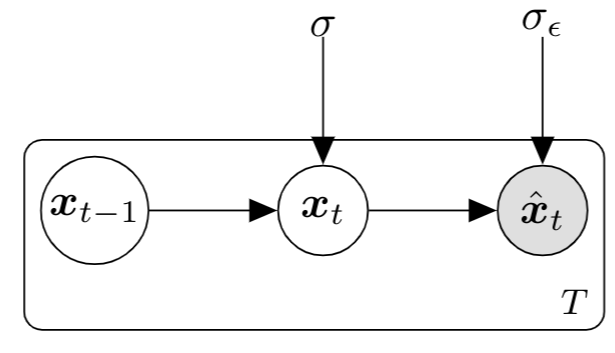

In [49]:
Image(filename='../data/initial_model2.png', width = 350) 

In [47]:
display(object_to_markdown(InitialModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    annealing_factor=1.0,
):
        
    pyro.module("initial_model", self)

    T_max = mini_batch_time.shape[-1]

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    sigma = torch.tensor(self.prior_params["sigma"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma_eps)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    return x
```

Initially, we wanted the prior on the initial trace positions to be uniform over the floor area. However we ran into domain problems, when attempting to define the variational posterior. We therefore decided to relax the prior a bit to a normal distribution with the same mean and variance.

We use mini batches of padded sequences during training, so we also need to provide a mask of padded observations. This mask also serves as a mask of missing observations, as these should essentially be handled identically. We are using the `torch` data loader protocol, and the specific implementation can be seen in `src/data/datasets.py`. Below, we extract a mini_batch of 4 traces:

In [94]:
mini_batch = floor_data[torch.arange(16, 24, 1)]
mini_batch_index = mini_batch[0]
mini_batch_length = mini_batch[1]
mini_batch_time = mini_batch[2]
mini_batch_position = mini_batch[3]
mini_batch_position_mask = mini_batch[4]

In [95]:
torch.manual_seed(123)
initial_model = InitialModel(floor_data)

Below, we can see the corresponding samples. Since they are essentially random walks (only conditioned on the previous observation), they dont really resemble the trace data in structure yet.

In [96]:
x = initial_model.model(*mini_batch)

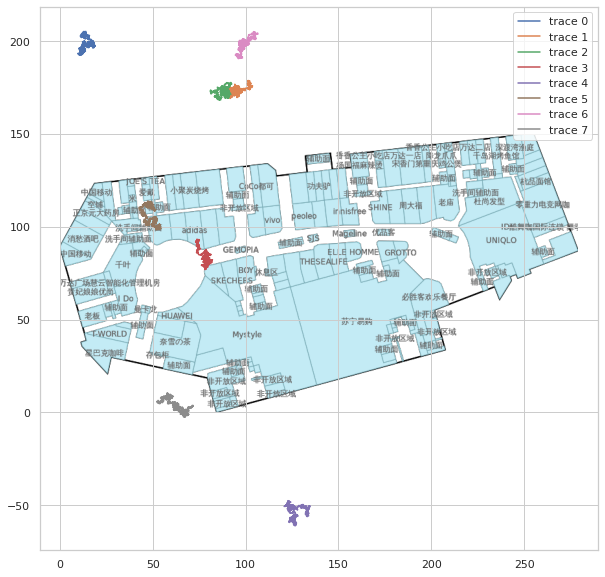

In [97]:
plt.figure(figsize=(10,10))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height))
plt.plot(*x.T, label=[f"trace {i}" for i in range(x.shape[0])])
plt.xlim(x[...,0].min()-5, x[...,0].max()+5)
plt.ylim(x[...,1].min()-5, x[...,1].max()+5)
plt.axis("equal")
plt.legend()
plt.show()

## Variational distribution
In the model, we sometimes observe $\hat {\boldsymbol x}_i $ as an observation of a latent variable $\boldsymbol x_i$. 
In order to use variational inference, we need an approximate posterior for the latent variable $\boldsymbol x_i$. **(Since the latent position is sampled quite frequently, if we just use a mean field approximation, we could end up training a lot of variational parameters.)** (new: Since a latent position $\boldsymbol x_t$ is dependent on its previous latent position $\boldsymbol x_{t-1}$, if we just use a mean field approximation this causial relationship is not preserved. Additionally, since the latent position is sampled quite frequently (100ms), using a mean field approxmation we could end up training a lot of variational parameters.)
Instead, with inspiration from [pyro's Deep Markov Model example](https://pyro.ai/examples/dmm.html), we use a parameterized function  $\tilde { \boldsymbol  x}_\theta : \mathbb{R}_{\geq 0} \mapsto \mathbb{R}^2$ for each trace to hopefully follow the latent path. We can then construct the variational posterior with variational parameters $\theta$ as 
$$
q(\boldsymbol x_i | \theta) = \mathcal N (\boldsymbol x_i \mid \tilde { \boldsymbol x}_\theta(t_i), s \mathbf I )
$$
where the diagonal variance $s$ is also a variational parameter.

We want a class of functions $\tilde{\boldsymbol x}_\theta$ that is quite flexible, yet doesn't have too many parameters to fit. We decided to look at functions of the form: 
$$
\tilde{\boldsymbol x}_\theta(t) = \boldsymbol\beta_0 + \sum_{i=1}^{10} \boldsymbol \alpha_i h( t - \boldsymbol \gamma_i).
$$
Where $h$ is the softplus function.
This has been implemented as the `TraceGuide` module.

In [98]:
display(object_to_markdown(TraceGuide))

```python
class TraceGuide(Module):

    def __init__(self, n=None, loc_bias=None, time_min_max=None):

        super().__init__()

        if n is None:
            n = 10
        
        # Setup basis coefficients
        self.register_parameter("coeffs", Parameter(torch.empty(n, 2,  device=device)))
        torch.nn.init.xavier_normal_(self.coeffs)

        # Setup location bias
        if loc_bias is not None:
            self.register_parameter("location_bias", Parameter(loc_bias))
        else:
            self.register_parameter("location_bias", Parameter(torch.zeros(2,  device=device)))

        # Setup time offsets (gamma)
        if time_min_max is not None:
            time_offset = torch.linspace(*time_min_max, n, device=device).view(-1, 1).tile(1, 2)
        else:
            time_offset = torch.linspace(0., 10., n, device=device).view(-1, 1).tile(1, 2)
        self.register_parameter("time_offset", Parameter(time_offset))

        self.register_parameter("log_scale", torch.nn.Parameter(torch.tensor(0.,  device=device)))
        
    def forward(self, x):
        """ Shape should be (some number of batch dims, 1) """
        x = x.unsqueeze(1) - self.time_offset
        x = torch.nn.functional.softplus(x)
        x = x * self.coeffs
        x = x.sum(1) + self.location_bias

        location = x
        scale = self.log_scale.exp()

        return location, scale
```

In [99]:
torch.manual_seed(123)
tg = TraceGuide(time_min_max=(0, 10), n=5)
tt = torch.linspace(0, 15, 100)
with torch.autograd.no_grad():
    basis_functions = torch.nn.functional.softplus(tt.view(-1, 1, 1) - tg.time_offset)
    basis_w_coeffs = basis_functions * tg.coeffs

We can train the parameters $\theta=(\beta_0, \alpha_1, \dots, \alpha_{10}, \gamma_1, \dots, \gamma_{10}, )$, to obtain quite flexible paths in $\mathbb{R}^2$. Below the basis for one of the dimensions is illustrated.

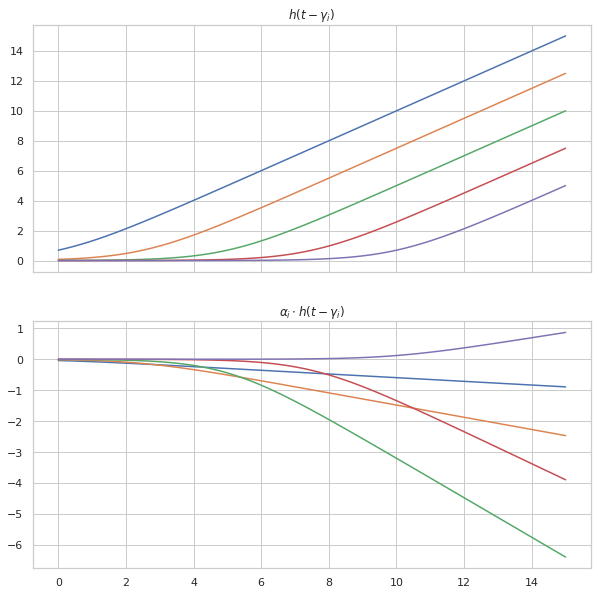

In [100]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10,10))

axes[0].plot(tt, basis_functions[..., 0])
axes[0].set_title("$h(t-\\gamma_i)$")
axes[1].plot(tt, basis_w_coeffs[..., 0])
axes[1].set_title("$\\alpha_i \\cdot h(t-\\gamma_i)$")
plt.show()

Below, a few traces for randomly generated basis coefficients can be seen. Also shown is the corresponding standard deviation, in this case initialized as $\exp[0] = 1$

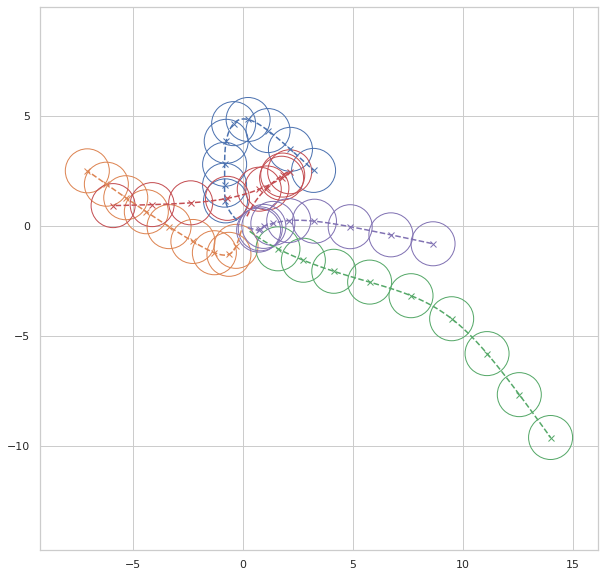

In [101]:
torch.manual_seed(126)
plt.figure(figsize=(10,10))
for i in range(5):
    tg = TraceGuide(time_min_max=(0, 10), n=5)
    with torch.autograd.no_grad():
        location, scale = tg(tt.view(-1,1))
    plt.plot(*location.T, "--", color=f"C{i}")
    ax = plt.gca()
    for j in range(19, len(tt), 10):
        ax.plot(*location[j], "x", color=f"C{i}")
        ax.add_patch(plt.Circle(location[j], scale, fill=False, color=f"C{i}"))
plt.axis("equal")   
plt.show()         

We used a mean field approximation for the other variational distributions eg. wifi locations and signal strengths. The corresponding guide function can be seen below:

In [102]:
display(object_to_markdown(InitialModel.guide))

```python
def guide(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    annealing_factor=1.0,
):

    pyro.module("initial_model", self)

    T_max = mini_batch_time.shape[-1]

    location = torch.zeros((len(mini_batch_index), T_max, 2), device=device)
    scale = torch.zeros((len(mini_batch_index),), device=device)

    for i, (index, length) in enumerate(zip(mini_batch_index, mini_batch_length)):
        l, s = self.trace_guides[index](mini_batch_time[i, :length].unsqueeze(1))
        location[i, :length, :] = l
        scale[i] = s

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            for t in pyro.markov(range(0, T_max)):
                sample(
                    f"x_{t}",
                    dist.Normal(location[:, t, :], scale.view(-1, 1))
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    return location, scale
```

## Model Training
Due to the size of the model / the number of parameters, the model is trained using the `src/models/initial_models.py` script. This allowed us to easily use the DTU HPC cluster for training. Below, we load a checkpoint of the trained model

In [103]:
checkpoint = torch.load("../checkpoints/initial-model.pt", map_location="cpu")
initial_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We can investigate the training loss over the course of training the model

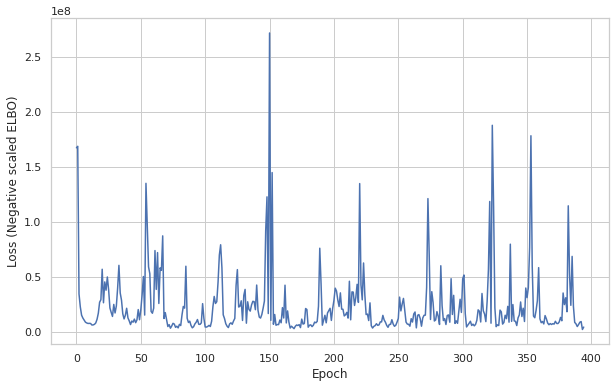

In [112]:
plt.figure(figsize=(10,6))
plt.plot(checkpoint["loss_history"])
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")
#plt.sc
plt.show()


In [105]:
loc_q.shape

torch.Size([5, 1280, 2])

In [106]:
loc_q[i, j, :]

tensor([44.1347, 29.8036])

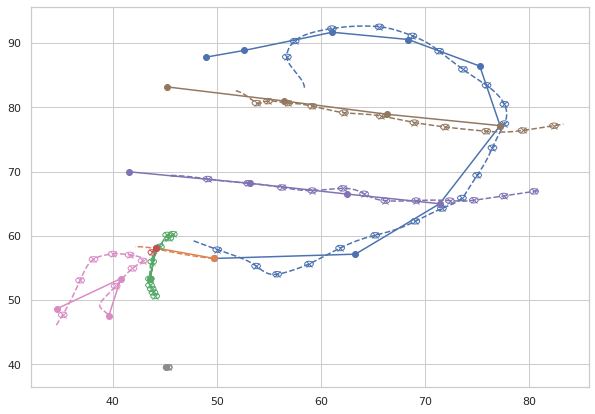

In [111]:
plt.figure(figsize=(10,7))

#plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height))

with torch.no_grad():
    loc_q, scale_q = initial_model.guide(*mini_batch)
    loc_q[loc_q==0] = float("nan")

for i in range(len(mini_batch_index)):
    x_hat = mini_batch_position[i, mini_batch_position_mask[i], :]
    
    plt.plot(*x_hat.T, "-o", color=f"C{i}")
    plt.plot(*loc_q[i].T, linestyle="--", color=f"C{i}")

    for j in range(100, mini_batch_length[i], 50):
        plt.plot(*loc_q[i, j, :], "x", color=f"C{i}")
        plt.gca().add_patch(plt.Circle(loc_q[i, j, :], scale_q[i].sqrt(), fill=False, color=f"C{i}"))
    
#plt.xlim((20, 100))
#plt.ylim((35, 95));

#plt.axis("equal")
plt.show()